In [36]:
import json
import numpy as np
from pathlib import Path
import matplotlib as mpl
from matplotlib import pyplot as plt

In [39]:
plt.rcParams.update({'font.size': 14})
mpl.rcParams['axes.linewidth'] = 1

In [3]:
problems = ["testem3-composite", "atlas-tilecal", "cms-hgcal", "cms-run3", "cms-hllhc",]
num_runs = 7

In [17]:
def get_times(results_dir, app):
    result = {p: {} for p in problems}
    for p in problems:
        throughput = []
        num_tracks = []
        for i in range(num_runs):
            with open(results_dir / app / p / f'{i}.json') as f:
                out = json.load(f)
                num_events = out["input"]["primary_options"]["num_events"]
                num_tracks.append(out["input"]["num_track_slots"])
                if app == 'celer-sim':
                    throughput.append(num_events / out["result"]["runner"]["time"]["total"])
                else:
                    throughput.append(num_events / out["result"]["time"]["total"])
        result[p]["num_tracks"] = num_tracks
        result[p]["throughput"] = throughput
    return result

In [47]:
celer_sim = get_times(Path("results/scaling-none"), "celer-sim")
celer_sim_ic = get_times(Path("results/scaling-init-charge"), "celer-sim")
celer_sim_ac = get_times(Path("results/scaling-reindex-along-step-action"), "celer-sim")

results = celer_sim
results_ic = celer_sim_ic
results_as = celer_sim_ac

In [48]:
celer_g4 = get_times(Path("results/scaling-none"), "celer-g4")
celer_g4_ic = get_times(Path("results/scaling-init-charge"), "celer-g4")
celer_g4_as = get_times(Path("results/scaling-reindex-along-step-action"), "celer-g4")

results = celer_g4
results_ic = celer_g4_ic
results_as = celer_g4_as

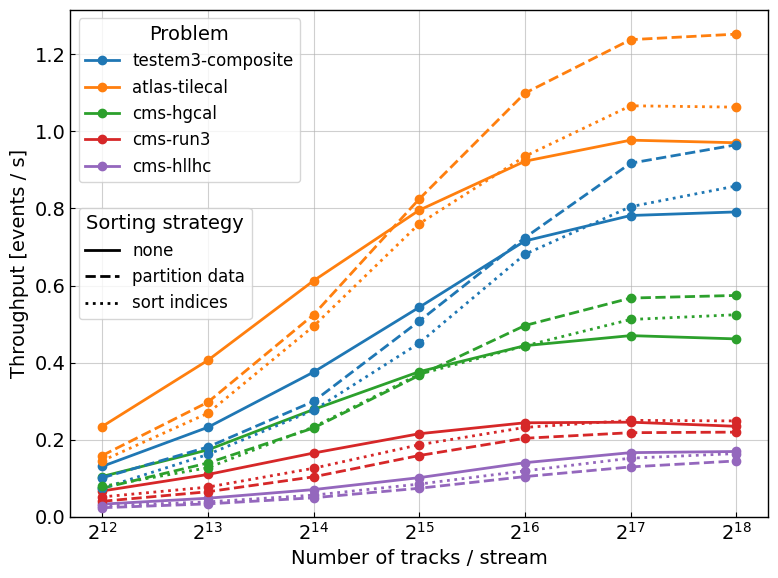

In [49]:
# Set up figure
fig, ax = plt.subplots(1, 1)
fig.set_facecolor('w')
fig.set_figheight(6)
fig.set_figwidth(8)

colors = plt.cm.tab10.colors[:num_runs]
ms = 12
lw = 2
problem_handles = []
sorting_handles = []

# Plot results
for i in range(len(problems)):
    k, v = list(results.items())[i]
    exp = np.array([np.log2(t) for t in v["num_tracks"]], dtype=int)
    threads = np.array(v["num_tracks"], dtype = int)
    h = ax.plot(threads, v["throughput"], color=colors[i], marker=".", markersize=ms, linewidth=lw, label=f"{k}")
    problem_handles.append(h[0])

for i in range(len(problems)):
    k, v = list(results_ic.items())[i]
    ax.plot(threads, v["throughput"], color=colors[i], linestyle="--", marker=".", markersize=ms, linewidth=lw)

for i in range(len(problems)):
    k, v = list(results_as.items())[i]
    ax.plot(threads, v["throughput"], color=colors[i], linestyle=":", marker=".", markersize=ms, linewidth=lw)

# Create the problem legend
leg = ax.legend(handles=problem_handles, loc='upper left', title='Problem', fontsize=12)

# Create the sorting legend
sorting_handles.append(ax.plot([0], [0], color='k', linestyle='-', linewidth=lw, label="none")[0])
sorting_handles.append(ax.plot([0], [0], color='k', linestyle='--', linewidth=lw, label="partition data")[0])
sorting_handles.append(ax.plot([0], [0], color='k', linestyle=':', linewidth=lw, label="sort indices")[0])
ax.legend(handles=sorting_handles, loc='center left', title='Sorting strategy', fontsize=12)

# Manually add back the problem legend
ax.add_artist(leg)

thread_labels = [fr"$2^{{{x}}}$" for x in exp]

ax.grid(True, which='major', alpha=0.6)
ax.set_xscale('log')
ax.set_xticklabels([], minor=True)
ax.set_xticks(threads, thread_labels)
ax.set_xlabel("Number of tracks / stream")
ax.set_ylabel("Throughput [events / s]")
ax.set_ylim((0, ax.get_ylim()[1]))
ax.tick_params(direction="in")
ax.xaxis.minorticks_off()

fig.tight_layout()
plt.show()
#fig.savefig('gpu-threads-g4.png')